# Artificial Intelligence II: HW1

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

## Loading Dataset

In [698]:

#Reading the csv file
#csv outline [index|url|rating|review]
df = pd.read_csv("/content/imdb-reviews.csv", sep='\t')

##### put the path for the test dataset here #######
test_df = pd.DataFrame()

#we make a column with {0, 1} based on rating
df["result"] = np.where(df["rating"] <= 4, 0, 1)

#updated csv file [index|url|rating|review|result]

## Data Pre-processing

In [699]:
#remove html tags
df['review'] = df['review'].apply(lambda s: re.sub('<.*?>','',s))

#remove the numbers
df['review'] = df['review'].str.replace('\d+', '', regex=True)

#stop-words from ntlk
stopwords = stopwords.words('english')

#words that appeared high as feature importance with out sentiment value so we remove them manually
my_stopwords = ['mstk', 'turkey', 'seagal', 'filmmakers', ' church', 'chaplin', 'career', 'london', 'author', 'books', 'aka', 'cameron', 'roberts',
                'blair', 'lee', 'kate', 'van', 'freddy', 'ron', 'dean', 'jones', 'ha', 'lloyd', 'ed', 'actor', 'lugosi', 'charles', 'ghosts', 'on dvd',
                'on', 'dvd', 'of', 'what', 'it', 'an', 'tony', 'today', 'jack', 'the', 'woman', 'men', 'scene', 'system', 'society', 'our', 'ryan', 'episodes', 'they', 'to', 'me',
                'kelly', 'in', 'vampires', 'themes', 'as', 'his', 'city', 'noir', 'american', 'era', 'paris', 'french', 'bill']
my_stopwords = stopwords.extend(my_stopwords)

#### Separate features (inputs) from targets (outputs)

In [700]:
X = df['review']
Y = df['result']

#### Split train and test sets

In [701]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=42)

In [702]:
#if case for running the test dataframe
if not test_df.empty:

  test_df['result'] = np.where(test_df['rating'] <= 4, 0, 1)
  X_test = test_df['review']
  Y_test = test_df['result']

#### Vectorization (Bag of Words)

In [703]:
count = CountVectorizer(lowercase=True, stop_words=my_stopwords, ngram_range=(1, 2), max_features=3000)
X_train_bag = count.fit_transform(X_train) # fit train
X_test_bag = count.transform(X_test)       # transform test

## Train a model & Tweaking the hyperparameters

### Logistic Regression

In [ ]:
#First we experiment with Logistic Regression model only with the train set
clf = LogisticRegression(penalty='l2', tol=0.1, C=0.1, solver="liblinear", max_iter=2000, random_state=42)
clf.fit(X_train_bag, np.ravel(Y_train))

########################################### Cross Validation ###########################################################

# clf = LogisticRegression(penalty='l2', tol=0.1, C=0.1, solver="liblinear", max_iter=2000, random_state=42)
# Kfold_cross_validate = KFold(n_splits=5)
# scoring = ['accuracy', 'precision', 'recall', 'f1']
# score = cross_validate(clf, X_train_bag, np.ravel(Y_train), scoring=scoring, cv=Kfold_cross_validate)
# print("Cross Validation Scores are {}".format(score))

########################################################################################################################

########################################### Finding the hyperparameters ################################################

# clf = LogisticRegression()
# scoring = ['accuracy', 'precision', 'recall', 'f1']
# grid_values = {'solver':['lbfgs', 'liblinear', 'newton-cg'], 'penalty':['l2'], 'C':[0.0001, 0.001, 0.01, 0.1, 1.0], 'tol':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 'max_iter':[2000]}
# grid_clf = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy')
# grid_clf.fit(X_train_bag, np.ravel(Y_train))
# print("Best hyperparameters",grid_clf.best_params_) #->Best hyperparameters {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}

########################################################################################################################


## Evaluate model's performance

#### Feature Importance

In [ ]:
####################### prints a list for the with important features #################################

def show_most_informative_features(vectorizer, clf, n=10):
  feature_names = vectorizer.get_feature_names_out()
  coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
  top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
  for (coef_1, fn_1), (coef_2, fn_2) in top:
      print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

show_most_informative_features(count, clf, n=10)

########################################################################################################

#### Metrics

In [ ]:
#Predict
predictions_train = clf.predict(X_train_bag)
predictions_test = clf.predict(X_test_bag)

# print(clf.n_features_in_)
# print(predictions_test)
# print(np.ravel(Y_test))

# print(predictions_test.sum())
# print(np.ravel(Y_test).sum())

# F-Score
f1_train = f1_score(Y_train, predictions_train)
f1_test = f1_score(Y_test, predictions_test)
print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_test)

# Precision
precision_train = precision_score(Y_train, predictions_train)
precision_test = precision_score(Y_test, predictions_test)
print("Precision score (train):", precision_train)
print("Precision score (validation):", precision_test)

# Recall
recall_train = recall_score(Y_train, predictions_train);
recall_test = recall_score(Y_test, predictions_test);
print("Recall score (train)", recall_train)
print("Recall score (validation)", recall_test)

# Accuracy
accuracy_train = accuracy_score(Y_train, predictions_train);
accuracy_test = accuracy_score(Y_test, predictions_test);
print("Accuracy score (train)", accuracy_train)
print("Accuracy score (validation)", accuracy_test)

## Plots to visualize the metrics for our predictions

##### Learning Curves

In [707]:
#learning curves
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  X, X_unused, y, y_unused = train_test_split(X_train_bag, Y_train, test_size=1-(times*0.1 + 0.001), random_state=42)

  c = LogisticRegression(penalty='l2', tol=0.1, C=0.1, solver="liblinear", max_iter=2000, random_state=42)
  c.fit(X, np.ravel(y))

  results_train = c.predict(X)
  results= c.predict(X_test_bag)
  f1_train = f1_score(y, results_train)
  f1 = f1_score(Y_test, results)

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times*0.1+0.1))


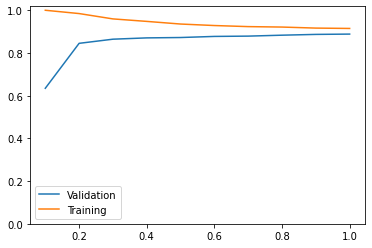

In [708]:
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

##### Confusion Matrix Display
$$\begin{bmatrix} True Negatives & False Positives \\ False Negatives & True Positives \end{bmatrix}$$

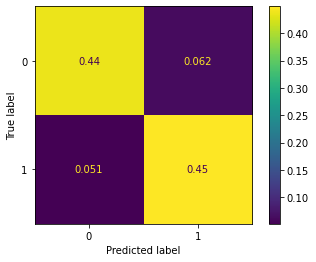

In [709]:
ConfusionMatrixDisplay.from_predictions(Y_test, predictions_test, normalize="all")